<a href="https://colab.research.google.com/github/hemu-08/octanet-task-2/blob/main/AI_Powered_Image_Tagger_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==4.30.2
!pip install git+https://github.com/openai/CLIP.git
!pip install keybert
!pip install sentence-transformers
!pip install timm
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.30.2 which is incompatible.
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-mk12dxlo
  Running command git clone --filter=blob:

Saving download.jpeg to download.jpeg


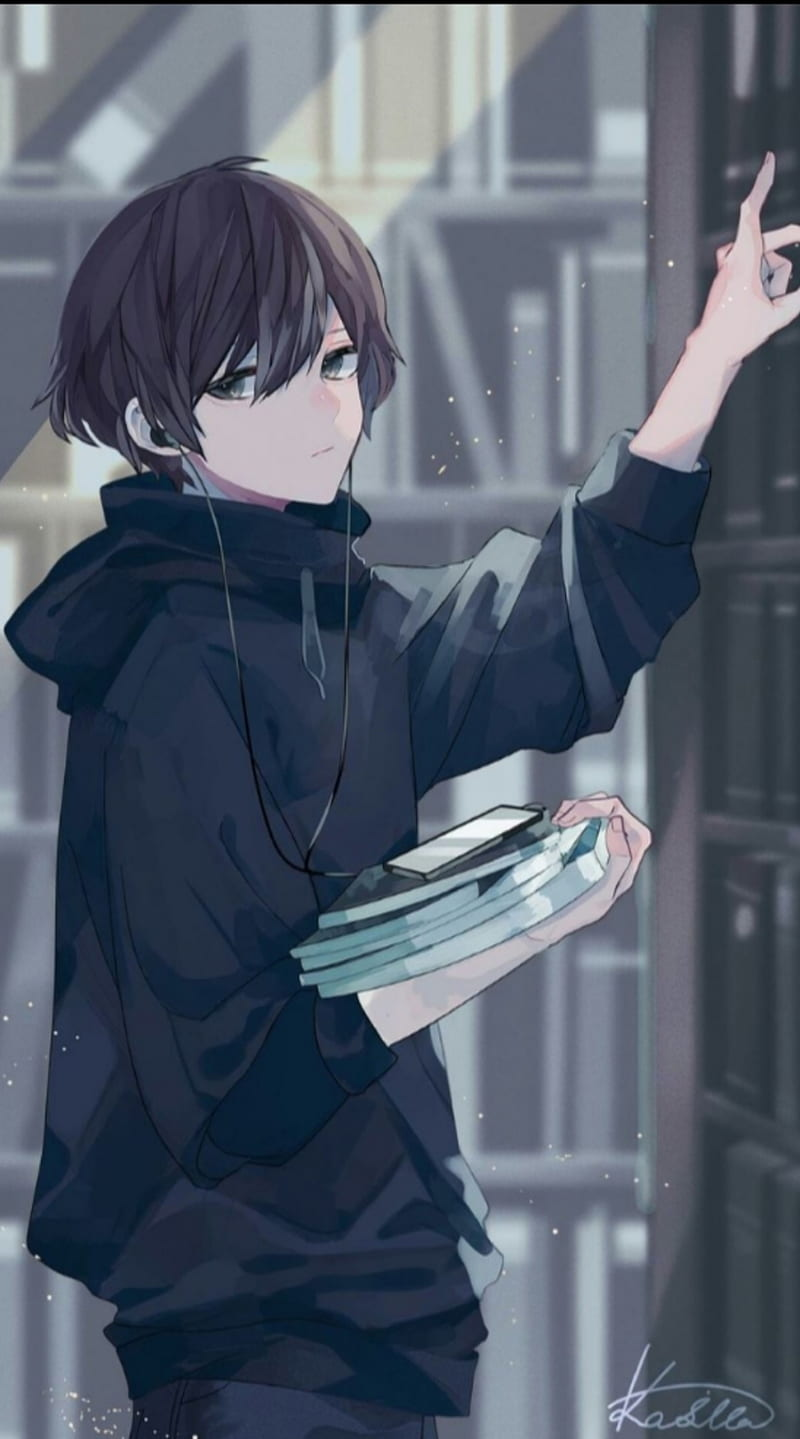

In [8]:
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display

# === OPTION 1: Upload image manually ===
from google.colab import files
uploaded = files.upload()

# Load the uploaded image (if you uploaded one)
for file_name in uploaded:
    image_path = file_name
    break

# === OPTION 2: Load from URL ===
# Uncomment and paste a URL below to use an image from the internet
# url = "https://your-image-url.jpg"
# response = requests.get(url)
# image = Image.open(BytesIO(response.content)).convert("RGB")
# image.save("url_image.jpg")
# image_path = "url_image.jpg"

# Load and show image
image = Image.open(image_path).convert("RGB")
display(image)


In [9]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

# Load BLIP processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda" if torch.cuda.is_available() else "cpu")

# Prepare image for model
inputs = processor(images=image, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

# Generate caption
caption_ids = model.generate(**inputs)
caption = processor.decode(caption_ids[0], skip_special_tokens=True)

# Display caption
print("Generated Caption:", caption)


Generated Caption: a man in a black hoodie holding a book


In [10]:
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer

# Load sentence-transformer model
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
kw_model = KeyBERT(model=sbert_model)

# Extract keywords
keywords = kw_model.extract_keywords(caption, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=5)
tags = [kw[0] for kw in keywords]

# Show extracted tags
print(" Extracted Tags:", tags)


 Extracted Tags: ['hoodie holding', 'black hoodie', 'holding book', 'hoodie', 'man black']


In [11]:
import clip
import torch
import torchvision.transforms as transforms

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# Preprocess image for CLIP
clip_image = clip_preprocess(image).unsqueeze(0).to(device)

# Prepare tag texts
text_tokens = clip.tokenize(tags).to(device)

# Get image and text embeddings
with torch.no_grad():
    image_features = clip_model.encode_image(clip_image)
    text_features = clip_model.encode_text(text_tokens)

# Normalize and compute cosine similarity
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (image_features @ text_features.T).squeeze(0)

# Filter tags based on similarity threshold
threshold = 0.25
final_tags = [tag for tag, score in zip(tags, similarity) if score.item() >= threshold]

# Print final results
print(" Final Visually Relevant Tags:", final_tags)


 Final Visually Relevant Tags: ['hoodie holding', 'black hoodie', 'holding book', 'hoodie']


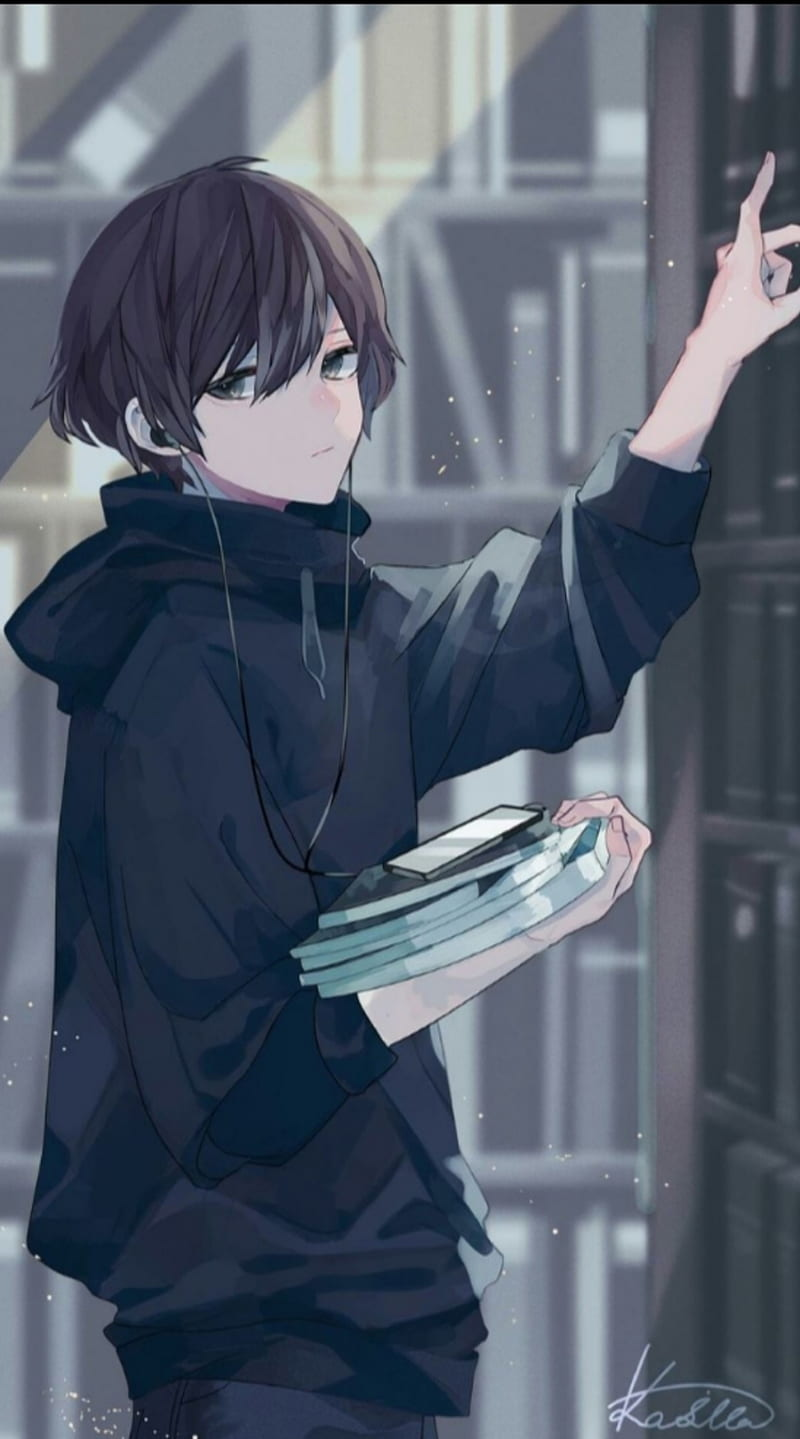

###  Image Caption

a man in a black hoodie holding a book


###  Initial Tags (from KeyBERT)

['hoodie holding', 'black hoodie', 'holding book', 'hoodie', 'man black']


###  Final Visually Relevant Tags (after CLIP filtering)

['hoodie holding', 'black hoodie', 'holding book', 'hoodie']


In [12]:
from IPython.display import display, Markdown

display(image)

display(Markdown("###  Image Caption"))
print(caption)

display(Markdown("###  Initial Tags (from KeyBERT)"))
print(tags)

display(Markdown("###  Final Visually Relevant Tags (after CLIP filtering)"))
print(final_tags)
